In [ ]:
!git clone https://github.com/pratikkayal/PlantDoc-Dataset.git data

Cloning into 'data'...
remote: Enumerating objects: 2670, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 2670 (delta 23), reused 40 (delta 22), pack-reused 2628 (from 1)
Receiving objects: 100% (2670/2670), 932.92 MiB | 26.38 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (2581/2581), done.


In [ ]:
!pwd
!ls data/train

/content
'Apple leaf'		 'grape leaf'		       'Tomato leaf'
'Apple rust leaf'	 'grape leaf black rot'        'Tomato leaf bacterial spot'
'Apple Scab Leaf'	 'Peach leaf'		       'Tomato leaf late blight'
'Bell_pepper leaf'	 'Potato leaf early blight'    'Tomato leaf mosaic virus'
'Bell_pepper leaf spot'  'Potato leaf late blight'     'Tomato leaf yellow virus'
'Blueberry leaf'	 'Raspberry leaf'	       'Tomato mold leaf'
'Cherry leaf'		 'Soyabean leaf'	       'Tomato Septoria leaf spot'
'Corn Gray leaf spot'	 'Squash Powdery mildew leaf'  'Tomato two spotted spider mites leaf'
'Corn leaf blight'	 'Strawberry leaf'
'Corn rust leaf'	 'Tomato Early blight leaf'


In [ ]:
import torchvision
import torch
import torch.nn as nn
import os

from torch.utils.data.dataloader import default_collate
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from tqdm import tqdm

transforms = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_data = ImageFolder(os.path.join("/", "content", "data", "train"), transform=transforms)
test_data = ImageFolder(os.path.join("/", "content", "data", "test"), transform=transforms)

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=32,
                                           shuffle=True,
                                           pin_memory=True,
                                           collate_fn=default_collate)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=32,
                                          shuffle=False,
                                          pin_memory=True,
                                          collate_fn=default_collate)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
mnet_v3 = models.mobilenet_v3_large(weights='DEFAULT')

In [ ]:
# Overwrite the last layer to output the correct number of classes.
mnet_v3.classifier[3] = nn.Linear(in_features=1280, out_features=28, bias=True)
for name, param in mnet_v3.named_parameters():
  # freeze all parameters except from final classification head
  param.requires_grad = name.startswith("classifier")

In [ ]:
LEARNING_RATE = 1e-3
EPOCHS = 3

optimizer = torch.optim.Adam(mnet_v3.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

loss_history = []

for _ in range(EPOCHS):
  # mostly following https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
  for data in tqdm(train_loader):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = mnet_v3(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

100%|██████████| 74/74 [02:42<00:00,  2.20s/it]


In [ ]:
mnet_v3.eval()
with torch.no_grad():
  num_correct = 0
  num_total = 0
  for tdata in tqdm(test_loader):
    inputs, labels = tdata
    outputs = mnet_v3(inputs)
    preds = torch.argmax(outputs, dim=1, keepdim=False)
    num_correct += torch.sum(preds == labels)
    num_total += labels.numel()

100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


In [ ]:
# e2e: 0.4661 w/ 1 epoch
# e2e: 0.5127 w/ 3 epochs
num_correct / num_total

tensor(0.5127)

# Pest Detection

In [23]:
from google.colab import drive

drive.mount('/content/drive')  # drive.flush_and_unmount() also useful

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import os
import pickle as pkl
import shutil

os.listdir('/content/drive/MyDrive/cs230')

base_path = os.path.join('/', 'content', 'drive', 'MyDrive', 'cs230')
with open(os.path.join(base_path, 'paths'), 'rb') as f:
  examples, labels = pkl.load(f)

with open(os.path.join(base_path, 'splits'), 'rb') as f:
  split_idxs = pkl.load(f)

In [7]:
################################################################################
# NOTE: if want to use existing ImageFolder dataset, following creates the kfold
# directories from the existing set, inefficient though it may be.
################################################################################

# train_path = os.path.join(base_path, "kfold", "train")
# test_path = os.path.join(base_path, "kfold", "test")

# if os.path.exists(train_path):
#   shutil.rmtree(train_path)

# if os.path.exists(test_path):
#   shutil.rmtree(test_path)

# for k in range(len(split_idxs)):
#   for cls in set(labels):
#     os.makedirs(os.path.join(train_path, str(k), cls), exist_ok=True)
#     os.makedirs(os.path.join(test_path, str(k), cls), exist_ok=True)

# for k, (train_idx, test_idx) in enumerate(split_idxs):
#   k_train_dir = os.path.join(train_path, str(k))
#   k_test_dir = os.path.join(test_path, str(k))

#   for idx_set, kpath in [(train_idx, k_train_dir), (test_idx, k_test_dir)]:
#     for idx in idx_set:
#       src = os.path.join(base_path, labels[idx], examples[idx])
#       dst = os.path.join(kpath, labels[idx], examples[idx])
#       shutil.copyfile(src, dst)

In [36]:
from torchvision.datasets import VisionDataset
from torchvision.datasets.folder import default_loader, is_image_file
from PIL import Image
from typing import Any


# Taken from https://pytorch.org/vision/main/_modules/torchvision/datasets/folder.html#DatasetFolder
def find_classes(directory: str) -> tuple[list[str], dict[str, int]]:
    """Finds the class folders in a dataset.

    See :class:`DatasetFolder` for details.
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


class PathDataset(VisionDataset):
    def __init__(self, root, paths, idxs, transform=None, target_transform=None,
                 loader=default_loader):
        """
        TODO: fill this out.
        :return: None.
        """
        super().__init__(root,
                         transform=transform,
                         target_transform=target_transform)

        classes, class_to_idx = self.find_classes(self.root)
        self.loader = loader
        self.classes = classes
        self.class_to_idx = class_to_idx

        samples = self.make_dataset(paths, idxs)
        self.samples = samples
        self.targets = [s[1] for s in samples]

    def make_dataset(self, paths, idxs) -> tuple[str, int]:
      """
      :param paths: list of paths, not all potentially used for this dataset.
      :param idxs: list of indices we want to use for this particular dataset.
      :return: tuples of (image path, class index)
      """
      image_paths = [paths[i] for i in idxs if is_image_file(paths[i])]
      labels = [self.class_to_idx[p.split(os.sep)[-2]] for p in image_paths]
      return list(zip(image_paths, labels))

    def find_classes(self, dir):
      return find_classes(dir)

    def __len__(self):
      return len(self.samples)

    def __getitem__(self, index: int) -> tuple[Any, Any]:
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

In [37]:
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

K = 0
paths = [os.path.join(base_path, labels[i], examples[i]) for i in range(len(examples))]
idxs = split_idxs[K][0]
train_dataset = PathDataset(base_path, paths=paths, idxs=idxs, transform=transforms)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [38]:
train_dataset[0]

(tensor([[[-0.3541, -0.7137, -0.6965,  ..., -0.4739, -0.5424, -0.6623],
          [-0.0458, -0.1486, -0.3027,  ..., -0.4568, -0.5767, -0.8849],
          [-0.2684, -0.3369, -0.1486,  ..., -0.5938, -0.6281, -1.2103],
          ...,
          [-1.0904, -1.2788, -1.1418,  ...,  0.5707,  0.5707,  0.4851],
          [-1.1932, -1.1589, -1.2617,  ...,  0.4166,  0.4166,  0.3138],
          [-1.3130, -1.2103, -1.5357,  ...,  0.2111,  0.3138,  0.2453]],
 
         [[ 0.3452,  0.0476,  0.1001,  ...,  0.2402,  0.1527, -0.0049],
          [ 0.7129,  0.5553,  0.3978,  ...,  0.2577,  0.1176, -0.2150],
          [ 0.5378,  0.4503,  0.5553,  ...,  0.1527,  0.0651, -0.5476],
          ...,
          [-0.4601, -0.6877, -0.5301,  ...,  1.0455,  1.0455,  0.9580],
          [-0.6001, -0.5476, -0.6702,  ...,  0.9055,  0.8880,  0.8179],
          [-0.7227, -0.6352, -0.9853,  ...,  0.7129,  0.8004,  0.7479]],
 
         [[-0.3753, -0.8110, -0.8458,  ..., -0.1487, -0.2010, -0.4450],
          [-0.0615, -0.1835,

In [53]:
# Sanity check the dataset was created correctly.

i, j = 0, 0
while i < len(train_dataset):
  label = train_dataset[i][1]
  if not is_image_file(examples[split_idxs[K][0][j]]):
    j += 1
    continue
  label2 = train_dataset.class_to_idx[labels[split_idxs[K][0][j]]]
  assert label == label2, f"{i=} {label=} {label2=}"

  i += 1
  j += 1

In [54]:
train_dataset.class_to_idx
# Note: small bug here where kfold was created as a false class with no examples; we just remove this during metric calculation. Training is not affected.

{'aphids': 0,
 'common brown scale': 1,
 'fungus gnats': 2,
 'healthy': 3,
 'kfold': 4,
 'mealybugs': 5,
 'spider mites': 6,
 'springtails': 7,
 'thrips': 8,
 'whiteflies': 9}

In [55]:
def load_mnet():
  mnet_v3 = models.mobilenet_v3_large(weights='DEFAULT')

  # Overwrite the last layer to output the correct number of classes.
  mnet_v3.classifier[3] = nn.Linear(in_features=1280, out_features=28, bias=True)
  for name, param in mnet_v3.named_parameters():
    # freeze all parameters except from final classification head
    param.requires_grad = name.startswith("classifier")

  return mnet_v3

In [56]:
LEARNING_RATE = 1e-3
EPOCHS = 3

def train(model, data_loader):
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
  loss_fn = nn.CrossEntropyLoss()

  loss_history = []

  for _ in range(EPOCHS):
    # mostly following https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
    for data in tqdm(data_loader):
      inputs, labels = data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      loss_history.append(loss.item())

  return loss_history

In [60]:
import matplotlib.pyplot as plt

def visualize(loss_history):
  plt.plot(range(len(loss_history)), loss_history)
  plt.xlabel("Steps")
  plt.ylabel("Loss")
  plt.title("Training Loss for Pest Detection")
  plt.show()

In [58]:
def evaluate(model, test_loader, num_classes):
  model.eval()
  with torch.no_grad():
    tracker = [{"fp": 0, "fn": 0, "tp": 0, "tn": 0} for _ in range(num_classes)]
    for tdata in tqdm(test_loader):
      inputs, labels = tdata
      outputs = model(inputs)
      preds = torch.argmax(outputs, dim=1, keepdim=False)

      for ref in range(num_classes):
        tp_mask = labels == ref
        tp_preds = torch.masked_select(preds, tp_mask)
        tracker[ref]["tp"] += torch.sum(tp_preds == ref).item()
        tracker[ref]["fn"] += torch.sum(tp_preds != ref).item()

        tn_preds = torch.masked_select(preds, ~tp_mask)
        tracker[ref]["tn"] += torch.sum(tn_preds != ref).item()
        tracker[ref]["fp"] += torch.sum(tn_preds == ref).item()
  return tracker

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 17/17 [01:10<00:00,  4.12s/it]


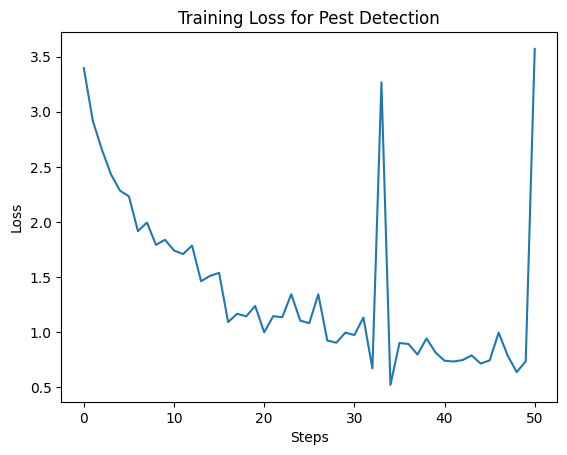

100%|██████████| 17/17 [01:14<00:00,  4.37s/it]


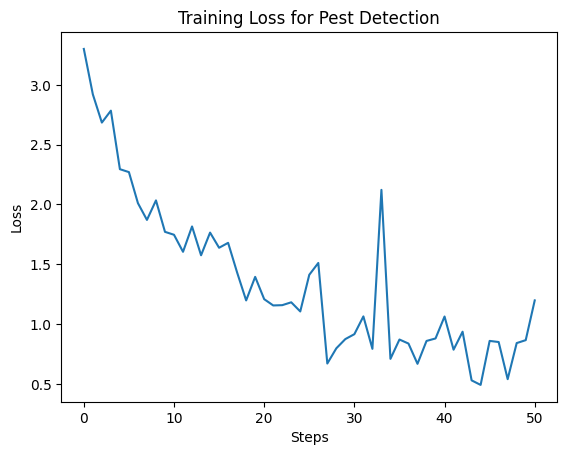

100%|██████████| 17/17 [01:06<00:00,  3.91s/it]


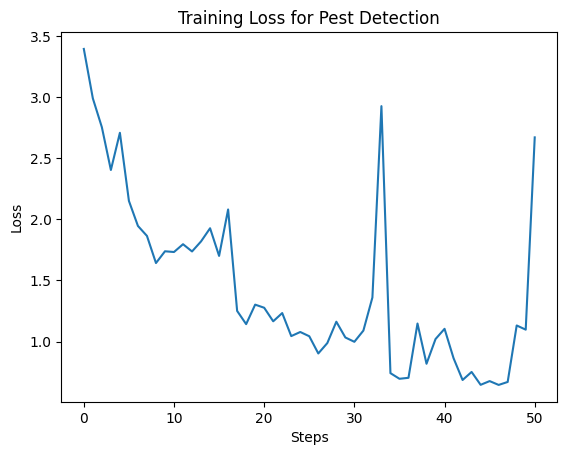

100%|██████████| 17/17 [01:06<00:00,  3.91s/it]


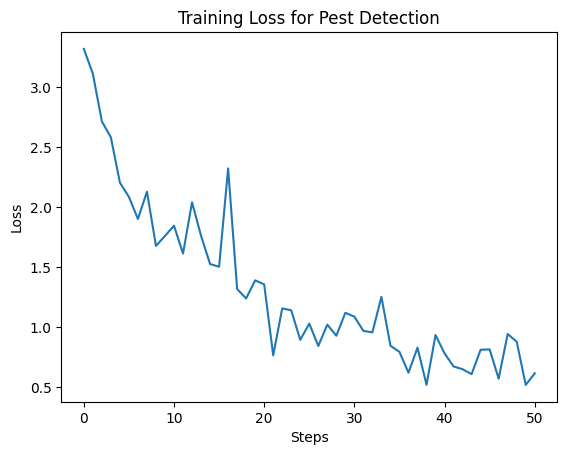

100%|██████████| 17/17 [01:14<00:00,  4.39s/it]


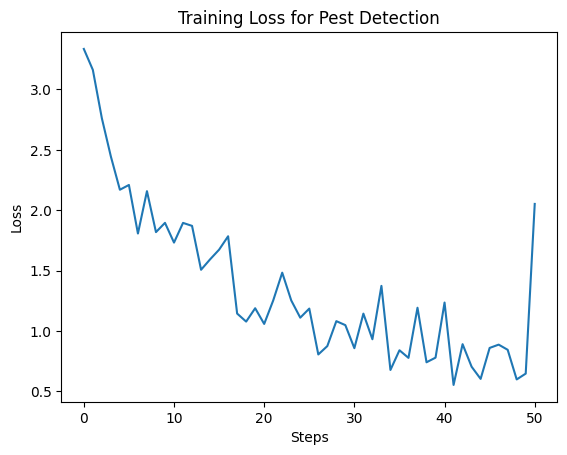

100%|██████████| 17/17 [01:06<00:00,  3.88s/it]


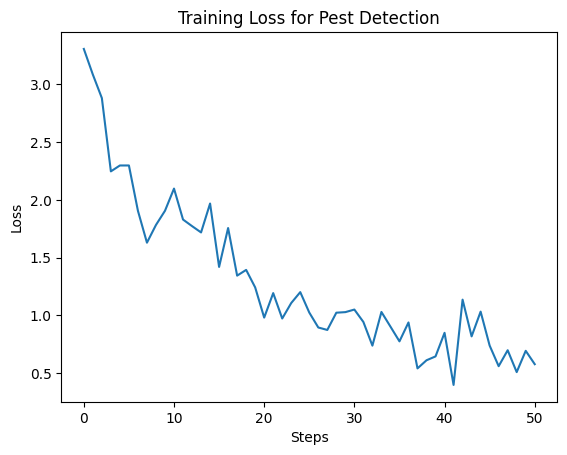

100%|██████████| 17/17 [01:15<00:00,  4.42s/it]


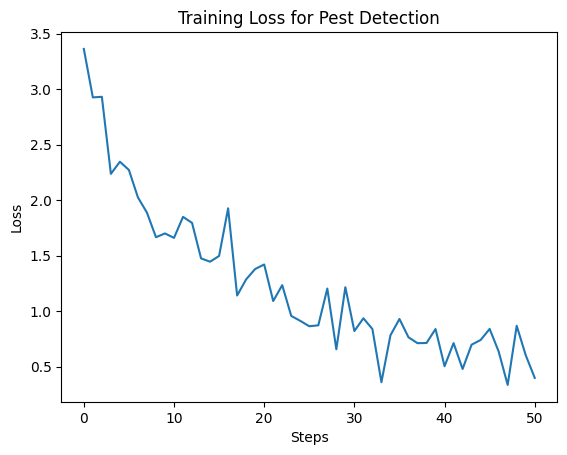

100%|██████████| 3/3 [00:10<00:00,  3.54s/it]


In [61]:
import torchvision
import torch
import torch.nn as nn
import os

from torch.utils.data.dataloader import default_collate
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from tqdm import tqdm

transforms = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

kfold = len(split_idxs)
kfold_metrics = []
paths = [os.path.join(base_path, labels[i], examples[i]) for i in range(len(examples))]

for k in range(kfold):
  train_idxs, test_idxs = split_idxs[k]
  train_data = PathDataset(base_path, paths=paths, idxs=train_idxs, transform=transforms)
  test_data = PathDataset(base_path, paths=paths, idxs=test_idxs, transform=transforms)

  train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=32,
                                            shuffle=True,
                                            pin_memory=True,
                                            collate_fn=default_collate)

  test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=32,
                                            shuffle=False,
                                            pin_memory=True,
                                            collate_fn=default_collate)

  model = load_mnet()
  loss_history = train(model, train_loader)
  visualize(loss_history)
  metrics = evaluate(model, test_loader, num_classes=len(train_data.class_to_idx))
  kfold_metrics.append(metrics)

In [62]:
with open("/content/drive/MyDrive/cs230/kfold_metrics", "wb") as f:
  pkl.dump(kfold_metrics, f)

print(kfold_metrics)

[[{'fp': 2, 'fn': 1, 'tp': 8, 'tn': 76}, {'fp': 2, 'fn': 1, 'tp': 8, 'tn': 76}, {'fp': 2, 'fn': 5, 'tp': 3, 'tn': 77}, {'fp': 8, 'fn': 3, 'tp': 15, 'tn': 61}, {'fp': 0, 'fn': 0, 'tp': 0, 'tn': 87}, {'fp': 2, 'fn': 5, 'tp': 3, 'tn': 77}, {'fp': 2, 'fn': 2, 'tp': 7, 'tn': 76}, {'fp': 0, 'fn': 2, 'tp': 7, 'tn': 78}, {'fp': 1, 'fn': 8, 'tp': 0, 'tn': 78}, {'fp': 9, 'fn': 1, 'tp': 8, 'tn': 69}], [{'fp': 14, 'fn': 0, 'tp': 8, 'tn': 64}, {'fp': 4, 'fn': 5, 'tp': 3, 'tn': 74}, {'fp': 0, 'fn': 6, 'tp': 2, 'tn': 78}, {'fp': 0, 'fn': 7, 'tp': 12, 'tn': 67}, {'fp': 0, 'fn': 0, 'tp': 0, 'tn': 86}, {'fp': 0, 'fn': 5, 'tp': 3, 'tn': 78}, {'fp': 0, 'fn': 6, 'tp': 3, 'tn': 77}, {'fp': 4, 'fn': 1, 'tp': 7, 'tn': 74}, {'fp': 8, 'fn': 6, 'tp': 3, 'tn': 69}, {'fp': 7, 'fn': 1, 'tp': 8, 'tn': 70}], [{'fp': 11, 'fn': 0, 'tp': 9, 'tn': 67}, {'fp': 0, 'fn': 3, 'tp': 5, 'tn': 79}, {'fp': 0, 'fn': 5, 'tp': 4, 'tn': 78}, {'fp': 7, 'fn': 2, 'tp': 17, 'tn': 61}, {'fp': 0, 'fn': 0, 'tp': 0, 'tn': 87}, {'fp': 1, 'fn'

Text(0.5, 1.0, 'Training Loss for Pest Detection')

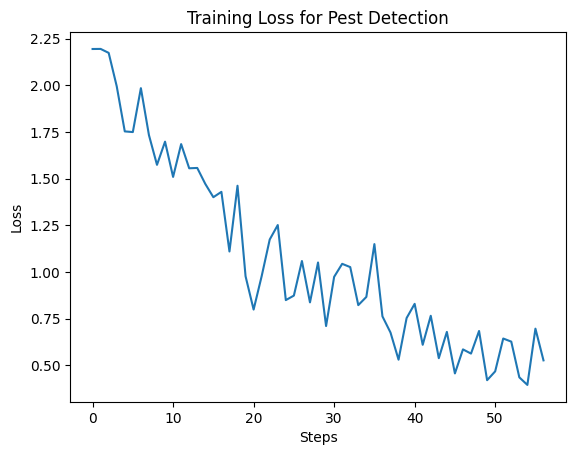

100%|██████████| 19/19 [01:06<00:00,  3.50s/it]


In [36]:
tracker

[{'fp': 23, 'fn': 2, 'tp': 57, 'tn': 520},
 {'fp': 0, 'fn': 10, 'tp': 48, 'tn': 544},
 {'fp': 3, 'fn': 20, 'tp': 40, 'tn': 539},
 {'fp': 25, 'fn': 8, 'tp': 120, 'tn': 449},
 {'fp': 16, 'fn': 9, 'tp': 50, 'tn': 527},
 {'fp': 4, 'fn': 20, 'tp': 40, 'tn': 538},
 {'fp': 7, 'fn': 5, 'tp': 55, 'tn': 535},
 {'fp': 10, 'fn': 17, 'tp': 42, 'tn': 533},
 {'fp': 11, 'fn': 8, 'tp': 51, 'tn': 532}]

In [38]:
# for cls in range(NUM_CLASSES):
#   acc = (tracker[cls]["tp"] + tracker[cls]["tn"]) / sum(tracker[cls].values())
#   recall = tracker[cls]["tp"] / (tracker[cls]["tp"] + tracker[cls]["fn"])
#   precision = tracker[cls]["tp"] / (tracker[cls]["tp"] + tracker[cls]["fp"])
#   print(f"Class {cls} metrics: {acc:.2f}% accuracy || {recall:.2f}% recall || {precision:.2f}% precision")

Class 0 metrics: 0.96% accuracy || 0.97% recall || 0.71% precision
Class 1 metrics: 0.98% accuracy || 0.83% recall || 1.00% precision
Class 2 metrics: 0.96% accuracy || 0.67% recall || 0.93% precision
Class 3 metrics: 0.95% accuracy || 0.94% recall || 0.83% precision
Class 4 metrics: 0.96% accuracy || 0.85% recall || 0.76% precision
Class 5 metrics: 0.96% accuracy || 0.67% recall || 0.91% precision
Class 6 metrics: 0.98% accuracy || 0.92% recall || 0.89% precision
Class 7 metrics: 0.96% accuracy || 0.71% recall || 0.81% precision
Class 8 metrics: 0.97% accuracy || 0.86% recall || 0.82% precision


In [26]:
# Clean up data for space.
if os.path.exists(train_path):
  shutil.rmtree(train_path)

if os.path.exists(test_path):
  shutil.rmtree(test_path)

In [22]:
# Load & analysis kfold metrics
import pickle as pkl

with open("/content/drive/MyDrive/cs230/kfold_metrics", "rb") as f:
  kfold_metrics = pkl.load(f)

NUM_CLASSES = 9
K = len(kfold_metrics)
for metrics in kfold_metrics:
  # small bug that leads to false class for kfold directory
  # just delete and move on
  metrics.pop(4)

for cls in range(NUM_CLASSES):
  accs = [(tracker[cls]["tp"] + tracker[cls]['tn']) / sum(tracker[cls].values()) for tracker in kfold_metrics]
  recalls = [tracker[cls]["tp"] / (tracker[cls]["tp"] + tracker[cls]["fn"]) for tracker in kfold_metrics if (tracker[cls]["tp"] + tracker[cls]["fn"]) > 0]
  precisions = [tracker[cls]["tp"] / (tracker[cls]["tp"] + tracker[cls]["fp"]) for tracker in kfold_metrics if (tracker[cls]["tp"] + tracker[cls]["fp"]) > 0]
  acc = sum(accs) / len(accs)
  recall = sum(recalls) / len(recalls)
  precision = sum(precisions) / len(precisions)
  print(f"Class {cls} metrics: {acc:.2f} accuracy || {recall:.2f} recall || {precision:.2f} precision")

Class 0 metrics: 0.86 accuracy || 0.88 recall || 0.43 precision
Class 1 metrics: 0.93 accuracy || 0.58 recall || 0.64 precision
Class 2 metrics: 0.90 accuracy || 0.38 recall || 0.64 precision
Class 3 metrics: 0.89 accuracy || 0.73 recall || 0.78 precision
Class 4 metrics: 0.91 accuracy || 0.42 recall || 0.61 precision
Class 5 metrics: 0.93 accuracy || 0.35 recall || 0.96 precision
Class 6 metrics: 0.96 accuracy || 0.77 recall || 0.81 precision
Class 7 metrics: 0.88 accuracy || 0.37 recall || 0.36 precision
Class 8 metrics: 0.92 accuracy || 0.61 recall || 0.64 precision


In [21]:
[m[5] for m in kfold_metrics]

[{'fp': 2, 'fn': 2, 'tp': 7, 'tn': 76},
 {'fp': 0, 'fn': 6, 'tp': 3, 'tn': 77},
 {'fp': 0, 'fn': 6, 'tp': 3, 'tn': 78},
 {'fp': 0, 'fn': 9, 'tp': 0, 'tn': 76},
 {'fp': 0, 'fn': 5, 'tp': 3, 'tn': 79},
 {'fp': 0, 'fn': 5, 'tp': 3, 'tn': 77},
 {'fp': 0, 'fn': 6, 'tp': 2, 'tn': 77}]

In [26]:
# train on full dataset and save

import torchvision
import torch
import torch.nn as nn
import os

from torch.utils.data.dataloader import default_collate
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from tqdm import tqdm

transforms = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# here, training & evaluating on same data
train_data = ImageFolder(os.path.join("/", "content", "drive", "MyDrive", "cs230"), transform=transforms)
test_data = ImageFolder(os.path.join("/", "content", "drive", "MyDrive", "cs230"), transform=transforms)

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=32,
                                           shuffle=True,
                                           pin_memory=True,
                                           collate_fn=default_collate)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=32,
                                          shuffle=False,
                                          pin_memory=True,
                                          collate_fn=default_collate)

mnet_v3 = models.mobilenet_v3_large(weights='DEFAULT')
# Overwrite the last layer to output the correct number of classes.
mnet_v3.classifier[3] = nn.Linear(in_features=1280, out_features=28, bias=True)
for name, param in mnet_v3.named_parameters():
  # freeze all parameters except from final classification head
  param.requires_grad = name.startswith("classifier")

LEARNING_RATE = 1e-3
EPOCHS = 3

optimizer = torch.optim.Adam(mnet_v3.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

loss_history = []

for _ in range(EPOCHS):
  # mostly following https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
  for data in tqdm(train_loader):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = mnet_v3(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())


mnet_v3.eval()
num_classes = 9
with torch.no_grad():
  tracker = [{"fp": 0, "fn": 0, "tp": 0, "tn": 0} for _ in range(num_classes)]
  for tdata in tqdm(test_loader):
    inputs, labels = tdata
    outputs = mnet_v3(inputs)
    preds = torch.argmax(outputs, dim=1, keepdim=False)

    for ref in range(num_classes):
      tp_mask = labels == ref
      tp_preds = torch.masked_select(preds, tp_mask)
      tracker[ref]["tp"] += torch.sum(tp_preds == ref).item()
      tracker[ref]["fn"] += torch.sum(tp_preds != ref).item()

      tn_preds = torch.masked_select(preds, ~tp_mask)
      tracker[ref]["tn"] += torch.sum(tn_preds != ref).item()
      tracker[ref]["fp"] += torch.sum(tn_preds == ref).item()

print(tracker)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 19/19 [01:05<00:00,  3.44s/it]

[{'fp': 76, 'fn': 3, 'tp': 56, 'tn': 467}, {'fp': 0, 'fn': 16, 'tp': 42, 'tn': 544}, {'fp': 2, 'fn': 25, 'tp': 35, 'tn': 540}, {'fp': 8, 'fn': 28, 'tp': 100, 'tn': 466}, {'fp': 32, 'fn': 9, 'tp': 50, 'tn': 511}, {'fp': 7, 'fn': 22, 'tp': 38, 'tn': 535}, {'fp': 7, 'fn': 7, 'tp': 53, 'tn': 535}, {'fp': 10, 'fn': 16, 'tp': 43, 'tn': 533}, {'fp': 5, 'fn': 21, 'tp': 38, 'tn': 538}]


In [27]:
for cls in range(NUM_CLASSES):
  acc = (tracker[cls]["tp"] + tracker[cls]["tn"]) / sum(tracker[cls].values())
  recall = tracker[cls]["tp"] / (tracker[cls]["tp"] + tracker[cls]["fn"])
  precision = tracker[cls]["tp"] / (tracker[cls]["tp"] + tracker[cls]["fp"])
  print(f"Class {cls} metrics: {acc:.2f}% accuracy || {recall:.2f}% recall || {precision:.2f}% precision")

Class 0 metrics: 0.87% accuracy || 0.95% recall || 0.42% precision
Class 1 metrics: 0.97% accuracy || 0.72% recall || 1.00% precision
Class 2 metrics: 0.96% accuracy || 0.58% recall || 0.95% precision
Class 3 metrics: 0.94% accuracy || 0.78% recall || 0.93% precision
Class 4 metrics: 0.93% accuracy || 0.85% recall || 0.61% precision
Class 5 metrics: 0.95% accuracy || 0.63% recall || 0.84% precision
Class 6 metrics: 0.98% accuracy || 0.88% recall || 0.88% precision
Class 7 metrics: 0.96% accuracy || 0.73% recall || 0.81% precision
Class 8 metrics: 0.96% accuracy || 0.64% recall || 0.88% precision


In [30]:
# os.makedirs("/content/drive/MyDrive/cs230/ckpt", exist_ok=True)
torch.save(mnet_v3.state_dict(), "/content/drive/MyDrive/cs230/ckpt")